In [28]:
#Import Libraries
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.ml.modeling.preprocessing import *

import json
import pandas as pd

In [29]:
#Create a session
with open('creds.json') as f:
    connection_parameters = json.load(f)
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "CC_DB"."PUBLIC"
Current Warehouse: "CC_WH"


In [30]:
# Creating a Snowpark DataFrame
application_record_sdf = session.table('APPLICATION_RECORD')
credit_record_sdf = session.table('CREDIT_RECORD')

In [31]:
# Number of records in each table
print(f"Number of records in APPLICATION_RECORD: {application_record_sdf.count()}")
print(f"Number of records in CREDIT_RECORD: {credit_record_sdf.count()}")

Number of records in APPLICATION_RECORD: 438557
Number of records in CREDIT_RECORD: 1048575


In [32]:
# Remove duplicates
duplicate_count = application_record_sdf.group_by('ID').agg(F.count(('ID'))).filter(F.col('ID') > 1).count()
print(f"Number of duplicate records in APPLICATION_RECORD: {duplicate_count}")
application_record_sdf = application_record_sdf.drop_duplicates()
print(f"Number of records in APPLICATION_RECORD after removing duplicates: {application_record_sdf.count()}")

Number of duplicate records in APPLICATION_RECORD: 438510
Number of records in APPLICATION_RECORD after removing duplicates: 438557


In [33]:
#Data Analysis

application_record_sdf.describe().show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"ID"               |"CODE_GENDER"  |"FLAG_OWN_CAR"  |"FLAG_OWN_REALTY"  |"CNT_CHILDREN"      |"AMT_INCOME_TOTAL"  |"NAME_INCOME_TYPE"    |"NAME_EDUCATION_TYPE"          |"NAME_FAMILY_STATUS"  |"NAME_HOUSING_TYPE"  |"DAYS_BIRTH"       |"DAYS_EMPLOYED"   |"FLAG_MOBIL"  |"FLAG_WORK_PHONE"   |"FLAG_PHONE"         |"FLAG_EMAIL"        |"OCCUPATION_TYPE"     |"CNT_FAM_MEMBERS"   |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
# Handle missing values
application_record_sdf = application_record_sdf.fillna(value='OTHER', subset=['OCCUPATION_TYPE'])
application_record_sdf.describe().show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"ID"               |"CODE_GENDER"  |"FLAG_OWN_CAR"  |"FLAG_OWN_REALTY"  |"CNT_CHILDREN"      |"AMT_INCOME_TOTAL"  |"NAME_INCOME_TYPE"    |"NAME_EDUCATION_TYPE"          |"NAME_FAMILY_STATUS"  |"NAME_HOUSING_TYPE"  |"DAYS_BIRTH"       |"DAYS_EMPLOYED"   |"FLAG_MOBIL"  |"FLAG_WORK_PHONE"   |"FLAG_PHONE"         |"FLAG_EMAIL"        |"OCCUPATION_TYPE"     |"CNT_FAM_MEMBERS"   |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [35]:
# Check unique values for each column
unique_values = []
for column in application_record_sdf.columns:
    unique_values.append([column, application_record_sdf.select(column).distinct().count()])
pd.DataFrame(unique_values, columns=['COLUMN_NAME','NUM_UNIQUE_VALUES'])

,COLUMN_NAME,NUM_UNIQUE_VALUES
0,ID,438510
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,CNT_CHILDREN,12
5,AMT_INCOME_TOTAL,866
6,NAME_INCOME_TYPE,5
7,NAME_EDUCATION_TYPE,5
8,NAME_FAMILY_STATUS,5
9,NAME_HOUSING_TYPE,6


In [36]:
# Dropping column FLAG_MOBIL since it has only one unique value
application_record_sdf = application_record_sdf.drop('FLAG_MOBIL')

The target column (Status) values : meanings 
- 0: 1-29 days past due
- 1: 30-59 days past due
- 2: 60-89 days overdue
- 3: 90-119 days overdue
- 4: 120-149 days overdue
- 5: Overdue or bad debts, write-offs for more than 150 days
- C: paid off that month
- X: No loan for the month

In [37]:
credit_record_sdf.show()

-----------------------------------------
|"ID"     |"MONTHS_BALANCE"  |"STATUS"  |
-----------------------------------------
|5001711  |0                 |X         |
|5001711  |-1                |0         |
|5001711  |-2                |0         |
|5001711  |-3                |0         |
|5001712  |0                 |C         |
|5001712  |-1                |C         |
|5001712  |-2                |C         |
|5001712  |-3                |C         |
|5001712  |-4                |C         |
|5001712  |-5                |C         |
-----------------------------------------



We want to flag customers as either high-risk(1) or low-risk(0). 
- So, we define that a customer is high-risk if during any month they are late on payments by 60 days or more.
- All other customers are low-risk.

In [38]:
credit_record_sdf.group_by('STATUS').count().sort('STATUS').show()


----------------------
|"STATUS"  |"COUNT"  |
----------------------
|0         |383120   |
|1         |11090    |
|2         |868      |
|3         |320      |
|4         |223      |
|5         |1693     |
|C         |442031   |
|X         |209230   |
----------------------



In [39]:
# Creating Target column for credit record
risk_status = credit_record_sdf.group_by('ID').agg(F.sum(F.iff(F.col('STATUS').in_(['2', '3', '4', '5']), 1, 0)).as_("CNT_LATE"))\
                                              .with_column('TARGET', F.when(F.col('CNT_LATE') > 0, 1).otherwise(0)).drop("CNT_LATE")
risk_status.show()

----------------------
|"ID"     |"TARGET"  |
----------------------
|5001711  |0         |
|5001712  |0         |
|5001713  |0         |
|5001714  |0         |
|5001715  |0         |
|5001717  |0         |
|5001718  |0         |
|5001719  |0         |
|5001720  |0         |
|5001723  |0         |
----------------------



In [40]:
risk_status.group_by('TARGET').agg(F.count('TARGET')).show()

------------------------------
|"TARGET"  |"COUNT(TARGET)"  |
------------------------------
|0         |45318            |
|1         |667              |
------------------------------



Highly imbalanced target variable

In [41]:
# Joining application record and risk status
application_record_sdf = application_record_sdf.join(risk_status, using_columns = 'ID', join_type ='inner')
application_record_sdf.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"     |"CODE_GENDER"  |"FLAG_OWN_CAR"  |"FLAG_OWN_REALTY"  |"CNT_CHILDREN"  |"AMT_INCOME_TOTAL"  |"NAME_INCOME_TYPE"    |"NAME_EDUCATION_TYPE"          |"NAME_FAMILY_STATUS"  |"NAME_HOUSING_TYPE"  |"DAYS_BIRTH"  |"DAYS_EMPLOYED"  |"FLAG_WORK_PHONE"  |"FLAG_PHONE"  |"FLAG_EMAIL"  |"OCCUPATION_TYPE"  |"CNT_FAM_MEMBERS"  |"TARGET"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
application_record_sdf.count()

36457

### FEATURE ENGINEERING

Variable Encoding

- FLAG_OWN_CAR : OrdinalEncoder
- FLAG_OWN_REALTY	: OrdinalEncoder
- AMT_INCOME_TOTAL : StandardScaler
- CODE_GENDER	: OneHotEncoder
- NAME_INCOME_TYPE : OneHotEncoder
- NAME_EDUCATION_TYPE : OneHotEncoder
- NAME_FAMILY_STATUS : OneHotEncoder
- NAME_HOUSING_TYPE :	OneHotEncoder
- CNT_CHILDREN : Custom Categories + OneHotEncoder
- CNT_FAM_MEMBERS : Custom Categories + OneHotEncoder
- OCCUPATION_TYPE : Custom Categories + OneHotEncoder
- DAYS_BIRTH : Transform to Years + StandardScaler
- DAYS_EMPLOYED : Transform to Years + Drop Outlier + StandardScaler
- FLAG_WORK_PHONE	: Drop
- FLAG_PHONE : Drop
- FLAG_EMAIL : Drop

In [43]:
# High Risk Ratio for CNT_CHILDREN
var_analysis = application_record_sdf.group_by('CNT_CHILDREN')
var_analysis = var_analysis.agg([F.count('CNT_CHILDREN').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis.sort('CNT_CHILDREN').show()

------------------------------------------
|"CNT_CHILDREN"  |"COUNT"  |"HIGH_RISK"  |
------------------------------------------
|0               |25201    |431          |
|1               |7492     |120          |
|2               |3256     |52           |
|3               |419      |12           |
|4               |63       |1            |
|5               |20       |0            |
|7               |2        |0            |
|14              |3        |0            |
|19              |1        |0            |
------------------------------------------



In [44]:
application_record_sdf = application_record_sdf.with_column('CNT_CHILDREN_IND', 
                                                            F.iff(F.col('CNT_CHILDREN') >= 2, 
                                                                  '2More', 
                                                                  F.to_varchar(F.col('CNT_CHILDREN'))
                                                                 )
                                                           )
application_record_sdf = application_record_sdf.drop('CNT_CHILDREN')
application_record_sdf[['ID', 'CNT_CHILDREN_IND']].show()

--------------------------------
|"ID"     |"CNT_CHILDREN_IND"  |
--------------------------------
|5008804  |0                   |
|5008805  |0                   |
|5008806  |0                   |
|5008808  |0                   |
|5008809  |0                   |
|5008810  |0                   |
|5008811  |0                   |
|5008812  |0                   |
|5008813  |0                   |
|5008814  |0                   |
--------------------------------



In [46]:
application_record_sdf[['ID', 'CNT_CHILDREN_IND']][application_record_sdf['CNT_CHILDREN_IND'] != '0'].show()

--------------------------------
|"ID"     |"CNT_CHILDREN_IND"  |
--------------------------------
|5008834  |1                   |
|5008835  |1                   |
|5008836  |2More               |
|5008837  |2More               |
|5008838  |1                   |
|5008839  |1                   |
|5008840  |1                   |
|5008841  |1                   |
|5008842  |1                   |
|5008856  |2More               |
--------------------------------



In [47]:
# High Risk Ratio for CNT_FAM_MEMBERS
var_analysis = application_record_sdf.group_by('CNT_FAM_MEMBERS')
var_analysis = var_analysis.agg([F.count('CNT_FAM_MEMBERS').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis.sort('CNT_FAM_MEMBERS').show()


---------------------------------------------
|"CNT_FAM_MEMBERS"  |"COUNT"  |"HIGH_RISK"  |
---------------------------------------------
|1.0                |6987     |139          |
|2.0                |19463    |313          |
|3.0                |6421     |105          |
|4.0                |3106     |46           |
|5.0                |397      |12           |
|6.0                |58       |1            |
|7.0                |19       |0            |
|9.0                |2        |0            |
|15.0               |3        |0            |
|20.0               |1        |0            |
---------------------------------------------



In [48]:
# Creating a new variable CNT_FAM_MEMBERS_IND with values 0, 1, 2 or 3More
application_record_sdf = application_record_sdf.with_column('CNT_FAM_MEMBERS_IND', 
                                                            F.iff(F.col('CNT_FAM_MEMBERS') >= 3, 
                                                                  '3More', 
                                                                  F.to_varchar(F.col('CNT_FAM_MEMBERS'))
                                                                 )
                                                           )
application_record_sdf = application_record_sdf.drop('CNT_FAM_MEMBERS')

application_record_sdf[['ID', 'CNT_FAM_MEMBERS_IND']].show()

-----------------------------------
|"ID"     |"CNT_FAM_MEMBERS_IND"  |
-----------------------------------
|5008804  |2                      |
|5008805  |2                      |
|5008806  |2                      |
|5008808  |1                      |
|5008809  |1                      |
|5008810  |1                      |
|5008811  |1                      |
|5008812  |1                      |
|5008813  |1                      |
|5008814  |1                      |
-----------------------------------



The age variable is very cryptic and hard to interpret.
Let's calculate the customer age in years.

Explanation of DAYS_BIRTH Variable:
Counts backwards from current day (0), -1 means yesterday

<Axes: title={'center': 'Age Distribution'}, xlabel='AGE'>

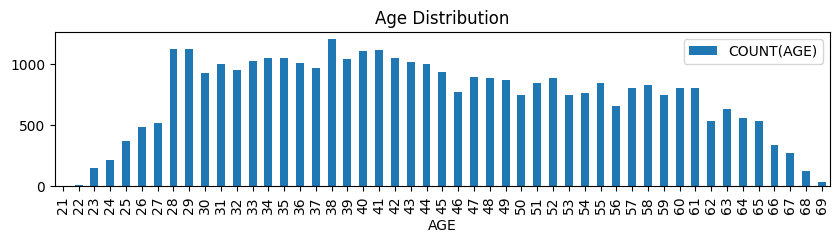

In [49]:
#The age variable is very cryptic and hard to interpret. So we Count backwards from current day (0), -1 means yesterday
# Calculate the age given the number of days
application_record_sdf = application_record_sdf.with_column('AGE', F.abs(F.floor(F.col('DAYS_BIRTH') / 365)))
application_record_sdf = application_record_sdf.drop('DAYS_BIRTH')

# Age Distribution
grouped_ages_df = application_record_sdf.group_by('AGE').agg(F.count('AGE')).sort('AGE')
grouped_ages_df.to_pandas().plot.bar(x='AGE', y='COUNT(AGE)', figsize=(10,2), title='Age Distribution')

<Axes: xlabel='WORKYEAR'>

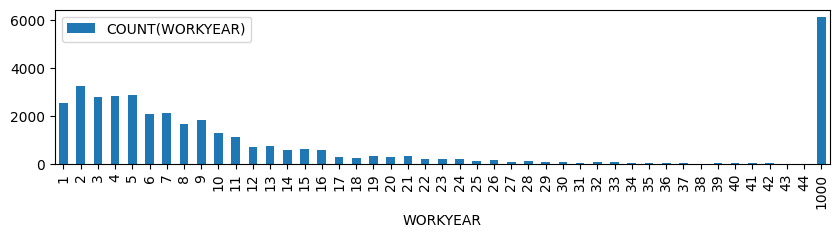

In [50]:
#Days Employment
# Calculate the workyears given the number of days of employment
application_record_sdf = application_record_sdf.with_column('WORKYEAR', F.abs(F.floor(F.col('DAYS_EMPLOYED') / 365)))
application_record_sdf = application_record_sdf.drop('DAYS_EMPLOYED')
grouped_workyears_df = application_record_sdf.group_by('WORKYEAR').agg(F.count('WORKYEAR')).sort('WORKYEAR').to_pandas()
grouped_workyears_df.plot.bar(x='WORKYEAR', figsize=(10,2))

In [51]:
# Lets filter out people with 1000 years of employment as it is not possible
application_record_sdf = application_record_sdf.filter(F.col('WORKYEAR') < 50)

In [52]:
# Occupation
# We do not need detailed level of occupation so we will group it into four diffrent categories, LABOURWORK, OFFICEWORK, HIGHTECHWORK and OTHER

var_analysis = application_record_sdf.group_by('OCCUPATION_TYPE').agg(F.count('OCCUPATION_TYPE').as_('COUNT'))
var_analysis = var_analysis.sort('COUNT').show()

-----------------------------------
|"OCCUPATION_TYPE"      |"COUNT"  |
-----------------------------------
|IT staff               |60       |
|Realty agents          |79       |
|HR staff               |85       |
|Secretaries            |151      |
|Waiters/barmen staff   |174      |
|Low-skill Laborers     |175      |
|Private service staff  |344      |
|Cleaning staff         |551      |
|Security staff         |592      |
|Cooking staff          |655      |
-----------------------------------



In [53]:
# Occupation Type
labour_work = ['Cleaning staff', 
               'Cooking staff', 
               'Drivers', 
               'Laborers', 
               'Low-skill Laborers', 
               'Security staff', 
               'Waiters/barmen staff']

office_work = ['Accountants', 
               'Core staff', 
               'HR staff', 
               'Medicine staff', 
               'Private service staff', 
               'Realty agents', 
               'Sales staff', 
               'Secretaries']

hightech_work = ['Managers', 
                 'High skill tech staff', 
                 'IT staff']

application_record_sdf = application_record_sdf.with_column('OCCUPATION_TYPE', 
                                                            F.iff(F.col('OCCUPATION_TYPE').in_(labour_work), 'LABOURWORK', 
                                                                 F.iff(F.col('OCCUPATION_TYPE').in_(office_work), 'OFFICEWORK', 
                                                                      F.iff(F.col('OCCUPATION_TYPE').in_(hightech_work), 'HIGHTECHWORK', 'OTHER')
                                                                      )
                                                                 )
                                                           )
application_record_sdf[['OCCUPATION_TYPE']].show()

---------------------
|"OCCUPATION_TYPE"  |
---------------------
|OTHER              |
|OTHER              |
|LABOURWORK         |
|OFFICEWORK         |
|OFFICEWORK         |
|OFFICEWORK         |
|OFFICEWORK         |
|OFFICEWORK         |
|LABOURWORK         |
|LABOURWORK         |
---------------------



### SnowML Preprocessing


In [54]:
application_record_sdf = application_record_sdf.drop(['FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'])

In [55]:
oe_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

my_oe_encoder = OrdinalEncoder(input_cols=oe_cols, output_cols=oe_cols)
my_oe_encoder.fit(application_record_sdf)
application_record_sdf = my_oe_encoder.transform(application_record_sdf)

In [56]:
# Prepare values for One-Hot-Encoding
ohe_cols = ['CODE_GENDER','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN_IND', 'CNT_FAM_MEMBERS_IND', 'OCCUPATION_TYPE','NAME_HOUSING_TYPE']

def fix_values(columnn):
    return F.upper(F.regexp_replace(F.col(columnn), '[^a-zA-Z0-9]+', '_'))

for col in ohe_cols:
    application_record_sdf = application_record_sdf.with_column(col, fix_values(col))

my_ohe_encoder = OneHotEncoder(input_cols=ohe_cols, output_cols=ohe_cols, drop_input_cols=True)
my_ohe_encoder.fit(application_record_sdf)
application_record_sdf = my_ohe_encoder.transform(application_record_sdf)

In [57]:
scaler_cols = ['AMT_INCOME_TOTAL', 'AGE', 'WORKYEAR']

my_scaler = StandardScaler(input_cols=scaler_cols, output_cols=scaler_cols)
my_scaler.fit(application_record_sdf)
application_record_sdf = my_scaler.transform(application_record_sdf)

In [58]:
application_record_sdf.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
# Saving transformed data into a new table
application_record_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED', mode='overwrite')

### Synthetic Minority Oversampling Technique (SMOTE)

In [60]:
# We have highly imbalanced data
application_record_sdf.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|1         |503      |
|0         |29819    |
----------------------



Instead of pulling back the data localy we create a Python Stored Procedure to do the sampling using the compute in Snowflake and save the result into a new table.

In order to create a Python Stored Procedure we need to create a Snowflake internal stage.

In [61]:
session.sql('CREATE OR REPLACE STAGE ML_PROCS').collect()
pd.DataFrame(session.sql('SHOW STAGES').collect())

,created_on,name,database_name,schema_name,url,has_credentials,has_encryption_key,owner,comment,region,type,cloud,notification_channel,storage_integration,endpoint,owner_role_type,directory_enabled
0,2025-03-27 17:48:52.022000-07:00,ML_PROCS,CC_DB,PUBLIC,,N,N,ACCOUNTADMIN,,None,INTERNAL,None,None,None,None,ROLE,N
1,2025-03-27 17:42:49.983000-07:00,gtshipxann,CC_DB,PUBLIC,,N,N,ACCOUNTADMIN,,None,INTERNAL TEMPORARY,None,None,None,None,ROLE,N
2,2025-03-27 17:42:45.310000-07:00,ynagdmhtfa,CC_DB,PUBLIC,,N,N,ACCOUNTADMIN,,None,INTERNAL TEMPORARY,None,None,None,None,ROLE,N


In [62]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake
def sproc_oversample_smote(session: Session, 
                           training_table: str, 
                           feature_cols: list,
                           target_col: str,
                           target_table: str) -> T.Variant:
    
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]
    
    # Oversample minority class via SMOTE
    from imblearn.over_sampling import SMOTE
    X_balance, y_balance = SMOTE().fit_resample(X,y)
    
    # Combine return values into single pandas dataframe
    X_balance[target_col] = y_balance
    
    # Persist dataframe in Snowflake table
    session.sql('DROP TABLE IF EXISTS {}'.format(target_table)).collect()
    session.write_pandas(X_balance, table_name=target_table, auto_create_table=True)
    
    # Getting model coefficients
    return "Successfully oversampled"

In [63]:
# Registering the function as a Stored Procedure. By pinning the version numbers of the the third-party python packages we makes sure that we use 
# the same version in Snowflake as we have installed locally, otherwise the latest version avalible in the Anaconda Snowflake channel will be used

sproc_oversample_smote = session.sproc.register(func=sproc_oversample_smote, 
                                                name='sproc_oversample_smote', 
                                                is_permanent=True, 
                                                replace=True,
                                                stage_location='@ML_PROCS',
                                                packages=[f'snowflake-snowpark-python',
                                                          f'scikit-learn==1.2.2',
                                                          f'imbalanced-learn==0.10.1'])

Package 'imbalanced-learn' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


In [64]:
training_table = 'CREDIT_RISK_PREPARED'
# get feature columns
feature_cols = application_record_sdf.columns
feature_cols.remove('TARGET')
target_col = 'TARGET'
target_table = 'CREDIT_RISK_PREPARED_BALANCED'

sproc_oversample_smote(
    training_table, 
    feature_cols, 
    target_col,
    target_table, 
    session=session
    )

'"Successfully oversampled"'

In [65]:
# Now our training data is balanced
train_data_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED')
train_data_sdf.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|0         |29819    |
|1         |29819    |
----------------------



In [66]:
session.close()